In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, log_loss

In [2]:
### SIMULATE SURVIVAL DATA ###

def sim_event_times(n_samples=3_000, n_features=20, random_state=0):

    X, y = make_regression(
        n_samples=n_samples, n_features=n_features, 
        n_informative=int(n_features*.4), random_state=random_state,
    )
    y = np.searchsorted(np.quantile(y, np.linspace(0,1, 10)), y)
        
    np.random.seed(random_state)
    betas = 365 * np.exp(-0.6 * y) / np.log(1.1)
    y_time = np.random.exponential(betas)
    
    return X, y_time


X, y_time = sim_event_times(n_samples=3_000, n_features=20)

In [3]:
### ADJUST EVENT TARGET ###

n_bins = 20
max_time = 700

y_time[(y_time > max_time)] = max_time
bin_edges = np.linspace(y_time.min(), y_time.max(), n_bins+1)
bin_edges[0] = 0

encoder = OneHotEncoder(
    categories = [np.arange(n_bins+1)],
    sparse = False, drop = None
).fit(np.zeros((1, 1)))

time = np.searchsorted(bin_edges[1:], y_time, side='right')
y_time_ohe = encoder.transform(time.reshape(-1, 1))
y_time_ohe = np.cumsum(y_time_ohe, 1)
y_time_ohe = y_time_ohe[:,:-1]

y_time_ohe.shape

(3000, 20)

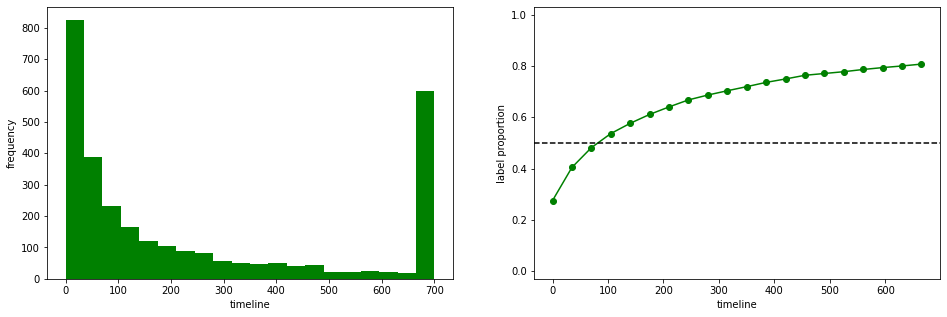

In [4]:
### PLOT EVENT TARGET AND LABEL PROPORTION ###

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(y_time, bins=bin_edges, color='green')
plt.xlabel('timeline'); plt.ylabel('frequency')
plt.subplot(1,2,2)
plt.plot(bin_edges[:-1], y_time_ohe.mean(axis=0), marker='o', color='green')
plt.ylim([-0.03,1.03]); plt.axhline(0.5, linestyle='--', c='black')
plt.xlabel('timeline'); plt.ylabel('label proportion')
plt.show()

In [5]:
### TRAIN-TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(
    X, y_time_ohe, test_size=0.25, shuffle=True, random_state=33
)

y_test = 1 - y_test

In [6]:
### FIT CHAIN CLASSIFIER ###

model = ClassifierChain(
    LogisticRegression(random_state=33, max_iter=2000),
    cv=5
)
model.fit(X_train, y_train)

ClassifierChain(base_estimator=LogisticRegression(max_iter=2000,
                                                  random_state=33),
                cv=5)

In [7]:
### POST-PROCESSING SURVIVAL CURVE PREDICTIONS ###

isoreg = IsotonicRegression(y_min=0, y_max=1, increasing=True)
x = np.arange(0, n_bins)

proba = model.predict_proba(X_test)

proba = Parallel(n_jobs=-1, verbose=1)(
    delayed(isoreg.fit_transform)(x, p) 
    for p in proba
)
proba = 1 - np.asarray(proba)

proba.shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    1.4s finished


(750, 20)

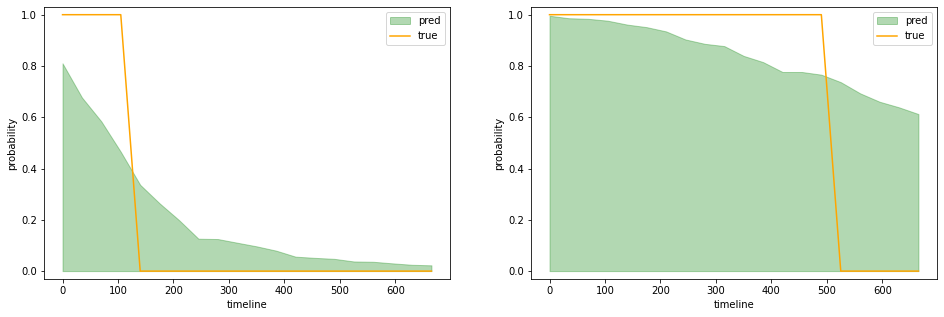

In [8]:
### PLOT PREDICTED SURVIVAL CURVES ###

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.fill_between(bin_edges[:-1], proba[5], color='green', alpha=0.3, label='pred')
plt.plot(bin_edges[:-1], y_test[5], color='orange', label='true')
plt.ylim([-0.03,1.03])
plt.xlabel('timeline'); plt.ylabel('probability'); plt.legend()
plt.subplot(1,2,2)
plt.fill_between(bin_edges[:-1], proba[15], color='green', alpha=0.3, label='pred')
plt.plot(bin_edges[:-1], y_test[15], color='orange', label='true')
plt.ylim([-0.03,1.03])
plt.xlabel('timeline'); plt.ylabel('probability'); plt.legend()
plt.show()

In [9]:
### COMPUTE SCORE ON TEST DATA ###

brier_scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(brier_score_loss)(true, pred, pos_label=1) 
    for true,pred in zip(y_test,proba)
)

logloss_scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(log_loss)(true, pred, labels=[0,1]) 
    for true,pred in zip(y_test,proba)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


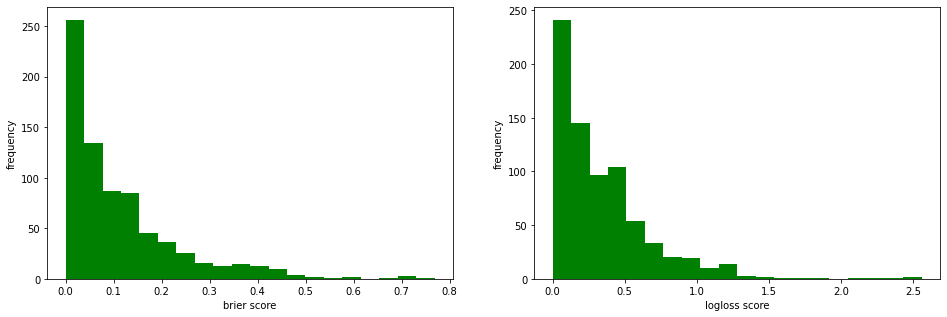

In [10]:
### PLOT TEST SCORE DISTRIBUTIONS ###

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.hist(brier_scores, bins=20, color='green')
plt.xlabel('brier score'); plt.ylabel('frequency')
plt.subplot(1,2,2)
plt.hist(logloss_scores, bins=20, color='green')
plt.xlabel('logloss score'); plt.ylabel('frequency')
plt.show()